# Mantis Rock Physics Library
### Author: G. Papageorgiou
In this notebook we showcase the palette of rock physics models in the mantis codebase.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import mantis_core.rock_physics as manRP
import mantis_core.rock_physics.fluid as manFL
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("plotting.mantis_plotting")
import numpy as np

We first define a fluid

In [2]:
water = manFL.Fluid.from_presets(name="Water", temperature=40, pressure=10)
co2 = manFL.Fluid.from_presets(name="CarbonDioxide", temperature=40, pressure=10)
water_co2_mix = manFL.FluidMix(fluid1=water, fluid2=co2)

Using in-situ values, we have a pallette of models that can be evaluated and calibrated to these in situ values. The calibration is such that the models are consistent with the in-situ values.

In [3]:
# in_situ = {"Vp": 3.8, "Vs": 1.8, "Rho": 2.5}
in_situ = {"Vp": 3.93, "Vs": 2.22, "Rho": 2.44}
water_co2_mix.saturation = 1
parameters = {
    "Phi": 0.25,
    "Km": 37.5,
    # "Km": 45.5,
    "fluid": water_co2_mix,
    "permeability": 1e-12,
    "patch_size": 0.0002,
    "bubble_radius": 0.0002,
    "Q_sls":15,
    "Log_omega_ref":0,
    "crack_density": 0.1,
    "aspect_ratio": 0.0001,
    "eps": 0.1,
    # "tau": np.log10(1 / 2 / np.pi / 35),
    "tau":10
}

pars = {**in_situ, **parameters}

In [4]:
models = {
    str(model.__name__).split(".")[-1]: {
        "name": model.Model.name,
        "type": model.Model.model_type.split(","),
    }
    for model in manRP.model_factory.ModelsBuild.models
}
calibrated = {model: manRP.models(identifier=model, **pars) for model in models}
calibrated["chapman"].eps = 0.005
for key, val in models.items():
    types = "\n".join(val["type"])
    print(f"{val['name']:-^40}\n{types}")

------Standard Linear Solid model-------
saturation-independent
 frequency-dependent
 isotropic
------------Gassmann's model------------
saturation-dependent
 frequency-independent
 isotropic
---Continuous 1-D Random Medium Model---
saturation-dependent
 frequency-dependent
 isotropic
---Continuous 3-D Random Medium Model---
saturation-dependent
 frequency-dependent
 isotropic
-------------Hudson's model-------------
saturation-dependent
 frequency-independent
 anisotropic
--------------White Model---------------
saturation-dependent
 frequency-dependent
 isotropic
-------Generic Rock Physics Model-------
saturation-independent
 frequency-independent
 isotropic
------------Chapman's Model-------------
saturation-dependent
 frequency-dependent
 anisotropic


Plotting the models as a function of saturation we can see that they have been calibrated to the in-situ values.

In [5]:
calibrated["gassmann"]

Model(Phi = 0.25, fluid = FluidMix(fluid1=Fluid(name='Water', modulus=2.38, viscosity=0.000654, density=0.997), fluid2=Fluid(name='CarbonDioxide', modulus=0.0458, viscosity=4.78e-05, density=0.629)), Kd = 19.60137393613112, Km = 37.5, Mu = 12.025296))

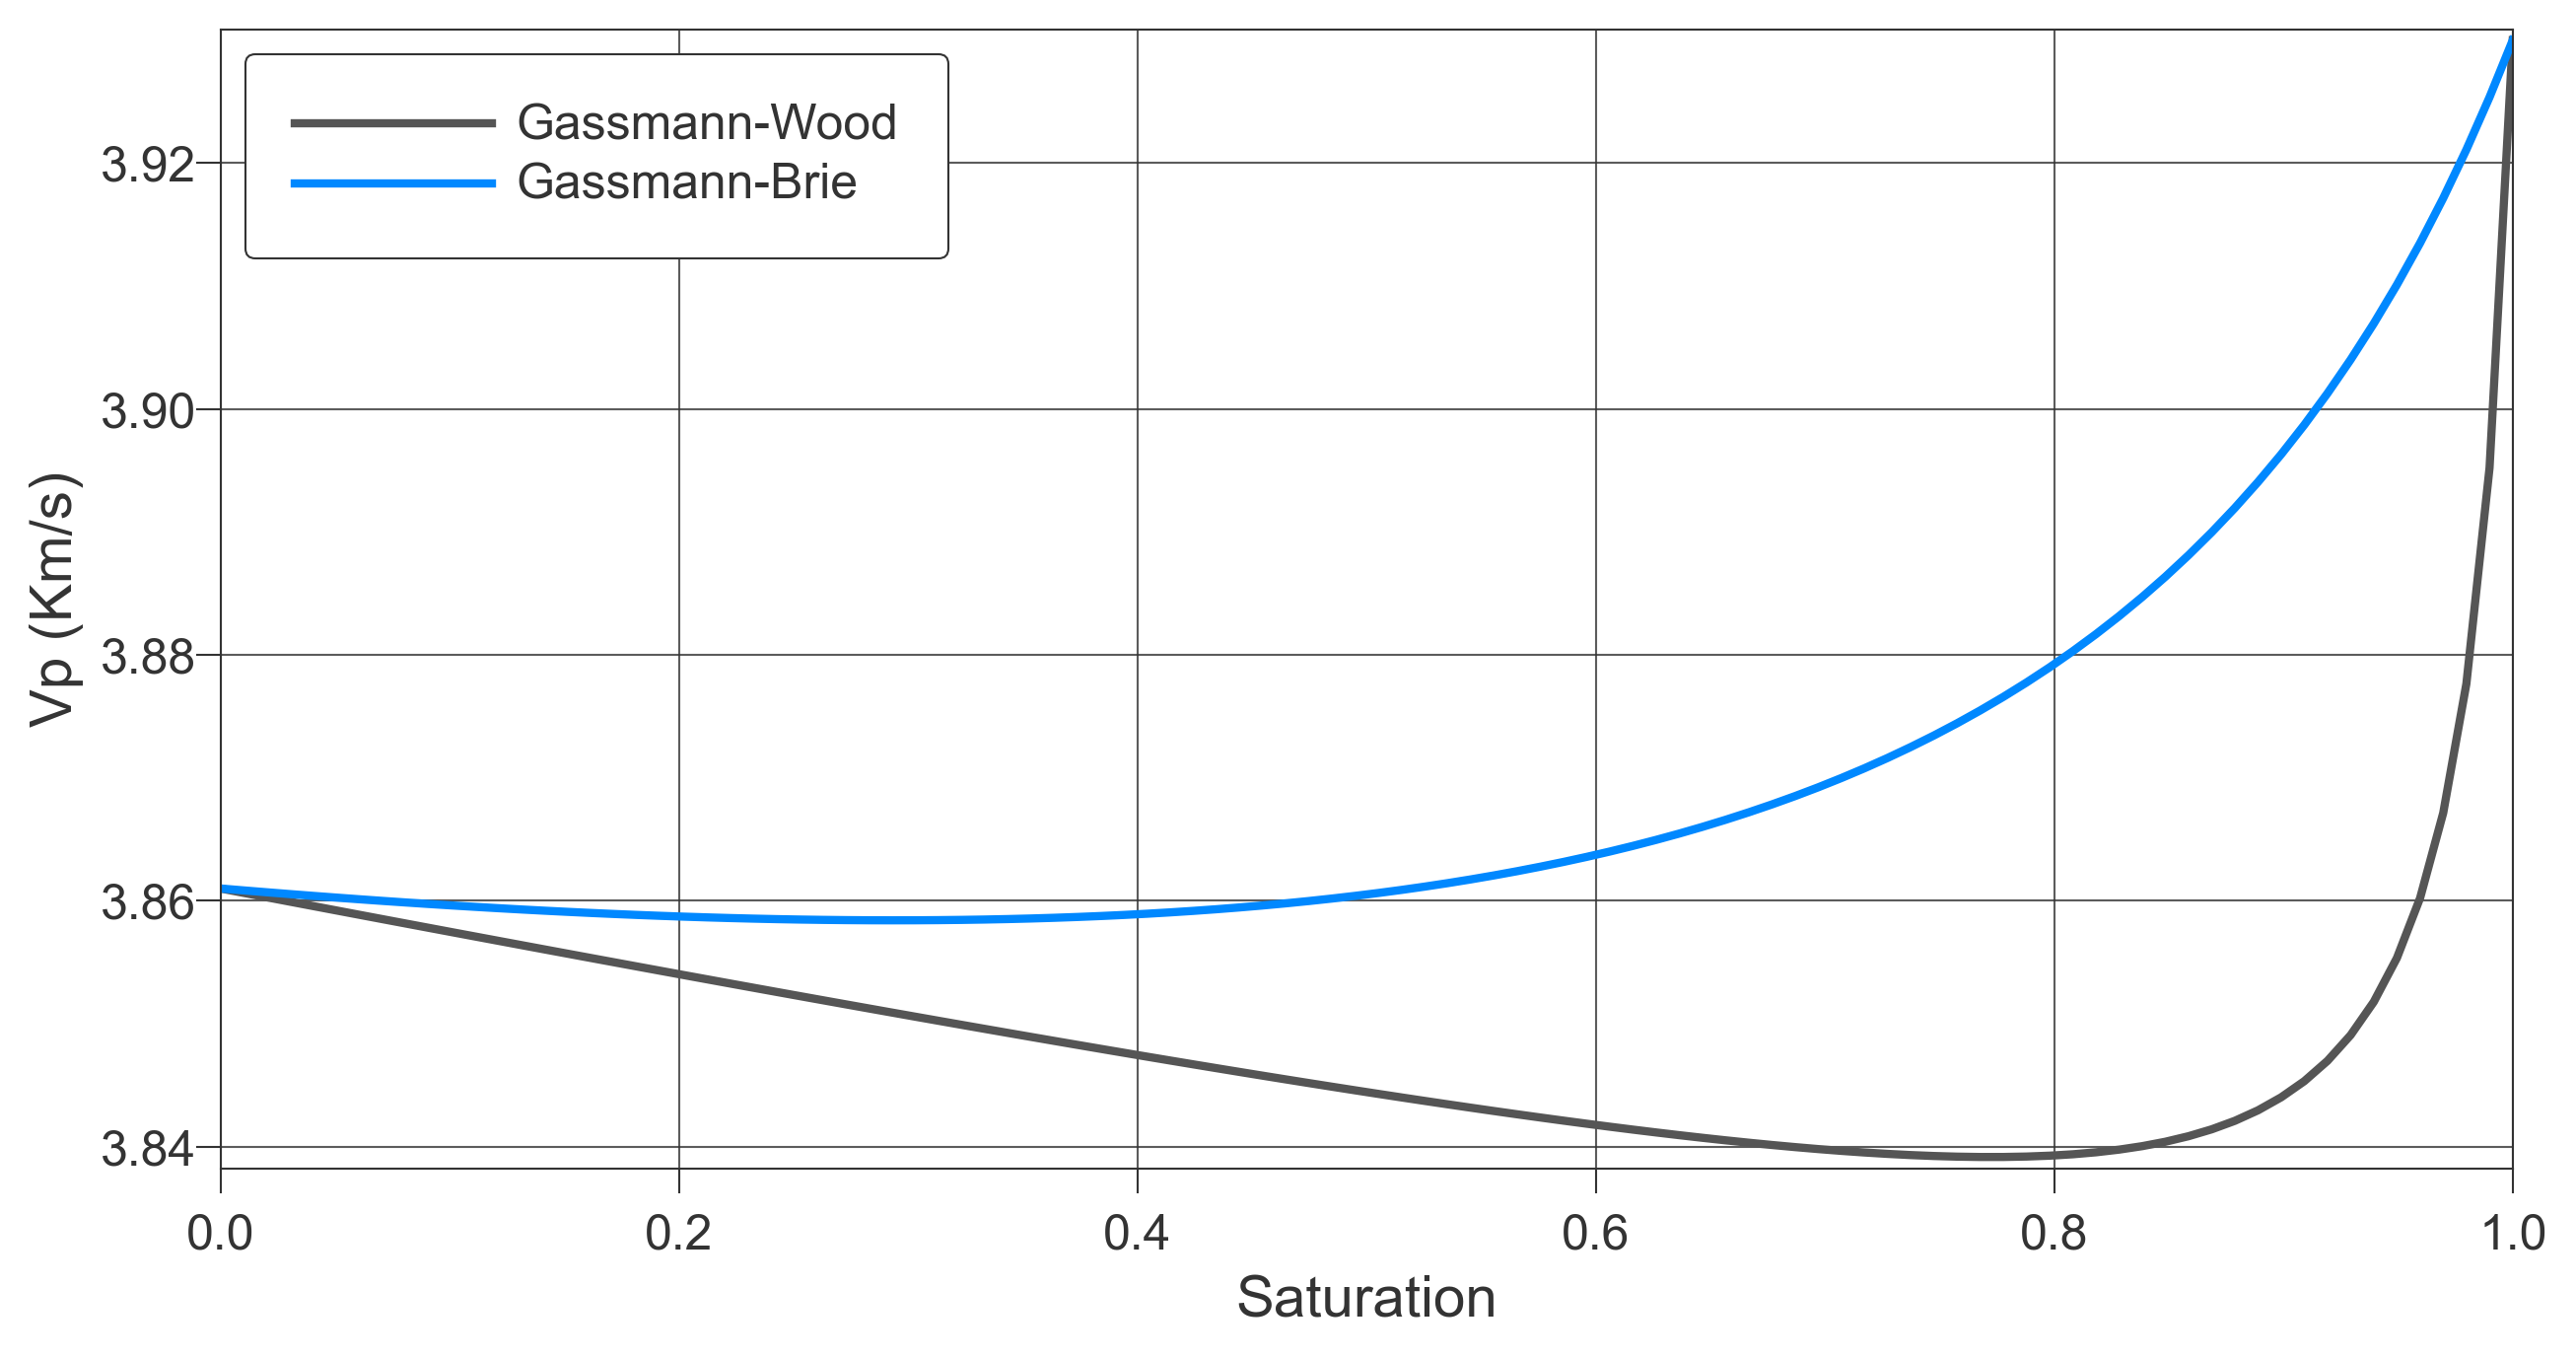

In [6]:
s = np.linspace(0, 1, 100)
water_co2_mix.saturation = 1
density = manRP.density.Density.from_insitu(
    Rho=in_situ["Rho"], fluid=water_co2_mix, Rho_d=2.65
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5), facecolor="w", dpi=300)
ax.set_facecolor("w")
data = np.empty((2, len(s)))
labels = ["Gassmann-Wood", "Gassmann-Brie"]
for j, sat in enumerate(s):
    water_co2_mix.saturation = sat
    water_co2_mix.patch_q = 1
    v = calibrated["gassmann"]
    data[0, j] = np.sqrt(np.real(v.Cij()[0, 0] / density()))
    water_co2_mix.patch_q = .1
    v = calibrated["gassmann"]
    data[1, j] = np.sqrt(np.real(v.Cij()[0, 0] / density()))
for i, d in enumerate(data):
    ax.plot(
        s, d, label=labels[i], lw=2
    )


ax.set_xlabel("Saturation")
ax.set_ylabel("Vp (Km/s)")

ax.legend()
plt.show()
plt.close()

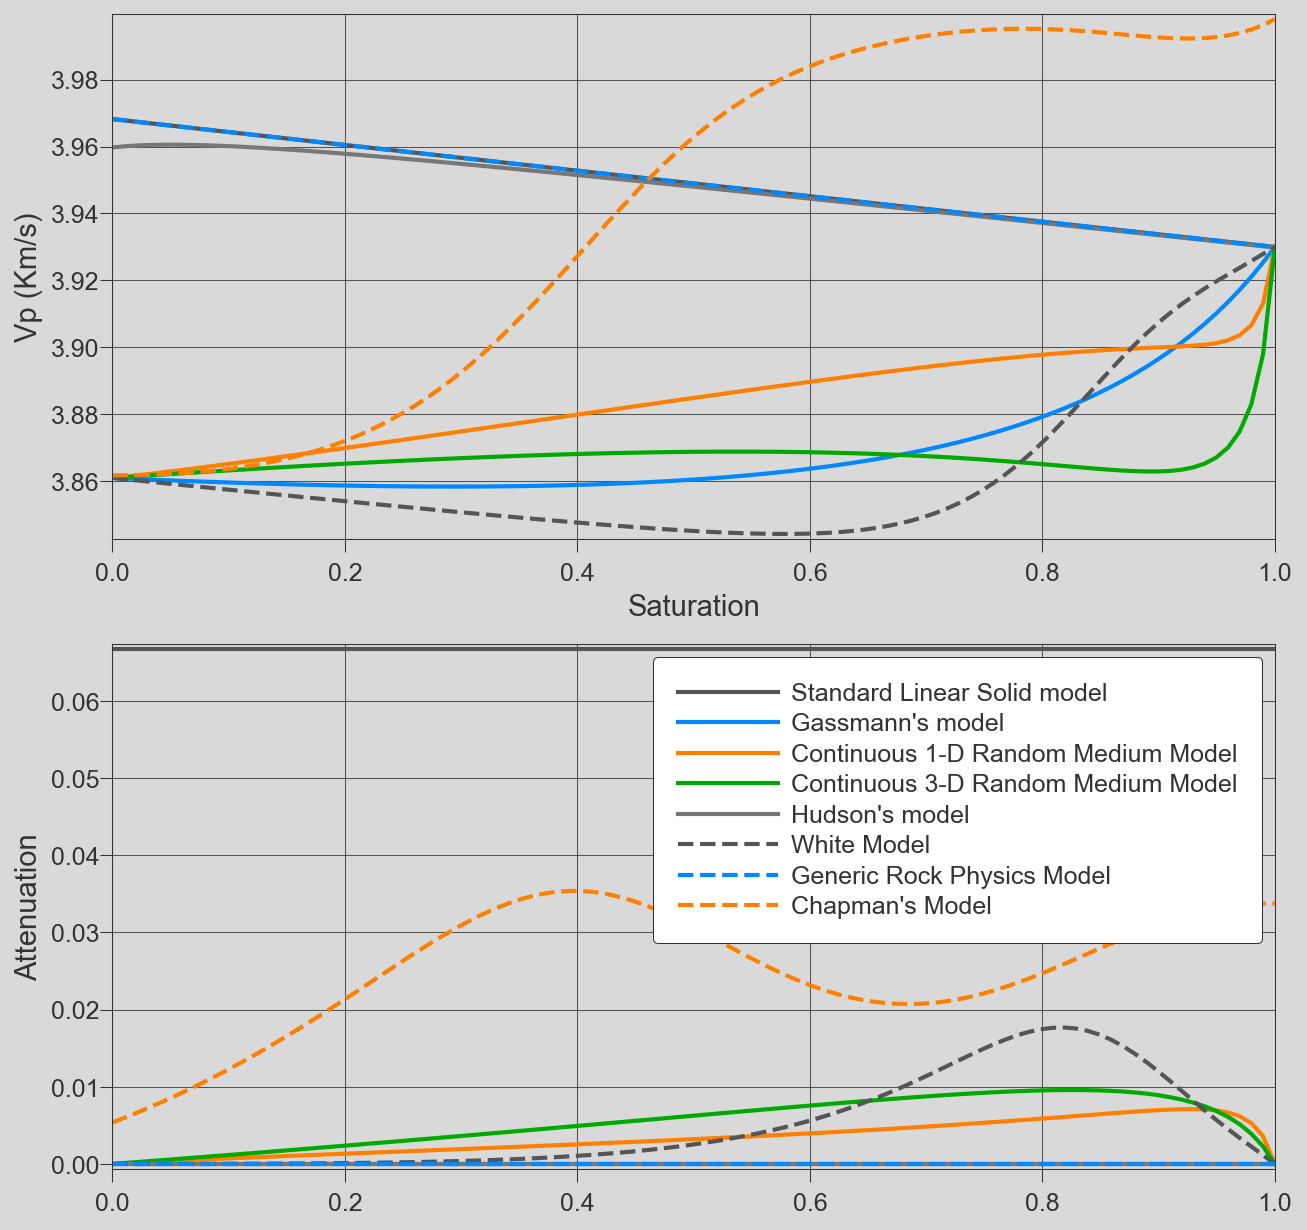

In [7]:
s = np.linspace(0, 1, 100)
water_co2_mix.saturation = 1
density = manRP.density.Density.from_insitu(Rho=in_situ["Rho"], fluid=water_co2_mix, Rho_d=2.65)

fig, ax = plt.subplots(2,1, figsize=(10,10))
data = np.empty((len(calibrated), len(s)))
att = data.copy()
for j, sat in enumerate(s):
    water_co2_mix.saturation = sat
    for i, model in enumerate(calibrated.items()):
        m, v = model
        data[i, j] = np.sqrt(np.real(v.Cij()[0,0] / density()))
        att[i, j]=np.abs(np.imag(v.Cij()[0,0]))/np.real(v.Cij()[0,0])
for i, d in enumerate(data):
    if i>4:
        dash = '--'
    else:
        dash = '-'
    ax[0].plot(s, d, label=calibrated[list(calibrated.keys())[i]].name, lw=2, linestyle=dash)
    ax[1].plot(
        s, att[i], label=calibrated[list(calibrated.keys())[i]].name, lw=2, linestyle=dash
    )

ax[0].set_xlabel("Saturation")
ax[0].set_ylabel("Vp (Km/s)")
ax[1].set_ylabel("Attenuation")

ax[1].legend()
plt.show()
plt.close()

Every model has a `Cij` method which is a function of log frequency. In the case of frequency independent models, this is a constant function. If called with no arguments, it is evaluated at the in-situ frequency which is by default set to 1Hz.

In [8]:
calibrated["hudson"].Cij()

array([[37.68228748, 13.63169548, 13.62593018,  0.        ,  0.        ,
         0.        ],
       [13.63169548, 37.68228748, 13.62593018,  0.        ,  0.        ,
         0.        ],
       [13.62593018, 13.62593018, 37.66058751,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  9.3097962 ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  9.3097962 ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        12.025296  ]])

In [9]:
calibrated["sls"].Cij(), calibrated["sls"].Cij(omega=-1)

(array([[37.685556+2.5123704j, 13.634964+0.9089976j, 13.634964+0.9089976j,
          0.      +0.j       ,  0.      +0.j       ,  0.      +0.j       ],
        [13.634964+0.9089976j, 37.685556+2.5123704j, 13.634964+0.9089976j,
          0.      +0.j       ,  0.      +0.j       ,  0.      +0.j       ],
        [13.634964+0.9089976j, 13.634964+0.9089976j, 37.685556+2.5123704j,
          0.      +0.j       ,  0.      +0.j       ,  0.      +0.j       ],
        [ 0.      +0.j       ,  0.      +0.j       ,  0.      +0.j       ,
         12.025296+0.8016864j,  0.      +0.j       ,  0.      +0.j       ],
        [ 0.      +0.j       ,  0.      +0.j       ,  0.      +0.j       ,
          0.      +0.j       , 12.025296+0.8016864j,  0.      +0.j       ],
        [ 0.      +0.j       ,  0.      +0.j       ,  0.      +0.j       ,
          0.      +0.j       ,  0.      +0.j       , 12.025296+0.8016864j]]),
 array([[35.22293551+0.49749909j, 12.74396635+0.17999952j,
         12.74396635+0.17999952j,

One can check that at the in-situ frequency, the models are consistent with the in-situ values and each other

In [10]:
calibrated["chapman"].eps = 0.0
[val.Cij(omega=0)[0,0] for model, val in calibrated.items()]

[(37.685556+2.5123703999999987j),
 37.685556,
 37.685556,
 37.685556,
 37.682287484858,
 37.685556,
 37.685556,
 (37.685556+0j)]

A reference for each model is provided as part of their docsting

In [11]:
for model in manRP.model_factory.ModelsBuild.models:
    if " frequency-dependent" in model.Model.model_type.split(","):
        print("{0:-^55}".format(f"{model.Model.name}", fill="center", align="center"))
        print(f"{model.Model.reference}\n\n")


--------------Standard Linear Solid model--------------

    Ursin, Björn, and Tommy Toverud. 
    'Comparison of seismic dispersion and attenuation models.' 
    Studia geophysica et geodaetica 46 (2002): 293-320.
    


----------Continuous 1-D Random Medium Model-----------

    Caspari, Eva, T. M. Müller, and Boris Gurevich.
    `Time-lapse sonic logs reveal patchy CO2 saturation in‐situ.`
    Geophysical Research Letters 38.13 (2011).
    


----------Continuous 3-D Random Medium Model-----------

    Caspari, Eva, T. M. Müller, and Boris Gurevich.
    `Time‐lapse sonic logs reveal patchy CO2 saturation in‐situ.`
    Geophysical Research Letters 38.13 (2011).
    


----------------------White Model----------------------

    - original reference:
    
        White, J. E. 
        "Computed seismic speeds and attenuation in rocks 
        with partial gas saturation." 
        Geophysics 40.2 (1975): 224-232.

    - Dutta-Seriff corrections:

        Dutta, N. C., and A. J. Serif